## Fiducial mode evolution and GDM parameters
In this file we evolve each mode in time from `τ_0` to the time of recombination `τ_rec`, and then obtain the fiducial functions $w_d(τ)$ and $c^2_{sd}(k,τ)$ (equation of state and sound speed).

In [1]:
import params as par
from params import *
from background import *

from scipy import integrate
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
import numba
from IPython.display import IFrame
from IPython.display import ScribdDocument
plt.rcParams.update(par.plot_params)

In [2]:
# set the τ and k arrays. These are currently both log-spaced.
τ_solve = np.geomspace(τ0, τ_rec, par.N)
k_solve = np.geomspace(par.k_low, par.k_high, par.K_SOLVE)

We are evolving the fluid equations from [seljak 1994](https://arxiv.org/abs/astro-ph/9406050), with the addition of neutrinos. You can find Seljak's fluid equations in the Seljak's paper embedded below (Eq. 9). We also use the initial conditions from the same paper, although I have recently learned that these may not be valid when the equation of state is varied. We set the initial values for the neutrino perturbations equal to those of the photon perturbations. In the cell below, the initial conditions are specified, and the function `DY_3fld` is defined, which returns the derivatives of the perturbations $\Phi, \delta_\gamma, v_\gamma, \delta_c, v_c, \delta_\nu, v_\nu$, given the values of these perturbations and the conformal time.

In [3]:
ScribdDocument(420438163, width=700, height=450,start_page=5,view_mode='scroll')

In [4]:
"""3 fluid"""
# create arrays for fluid variables
Φ0, δɣ0, vɣ0, δc0, vc0, δν0, vν0 = np.zeros(K_SOLVE), np.zeros(K_SOLVE), np.zeros(K_SOLVE),\
    np.zeros(K_SOLVE), np.zeros(K_SOLVE), np.zeros(K_SOLVE),\
    np.zeros(K_SOLVE)

# set initial conditions
Φ0 = np.ones(K_SOLVE)
δɣ0 = -2*Φ0*(1 + 3*y(τ0)/16)
vɣ0 = -k_solve/(ℋ(τ0)) * (δɣ0/4 + (2*k_solve**2 * (1 + y(τ0))*Φ0) /
                          (9*(ℋ(τ0))**2 * (4./3. + y(τ0))))
δc0 = .75 * δɣ0
vc0 = vɣ0
δν0 = δɣ0
vν0 = vɣ0


Y0 = np.array([Φ0, δɣ0, vɣ0, δc0, vc0, δν0, vν0])

# the numba decorator 'compiles' the function the
# first time it is called and caches a binary version
# to speed up subsequent calls.
@numba.jit(nopython=True) 
def DY_3fld(τ, Y):
    dY = np.zeros((7, K_SOLVE))
    Φ = Y[0, :]
    δɣ = Y[1, :]
    vɣ = Y[2, :]
    δc = Y[3, :]
    vc = Y[4, :]
    δν = Y[5, :]
    vν = Y[6, :]

    # compute background quantities for the current
    # time step.
    ℋi = 2*α*(α*τ/τr + 1)/(α**2 * (τ**2/τr) + 2*α*τ)
    ai = a_eq*((α*τ/τr)**2 + 2*α*τ/τr)
    ybi = 1.68*ai*Ωb0/Ωr0
    Ωbi = Ωb0 * ai**-3.
    Ωci = Ωc0 * ai**-3.
    Ωɣi = Ωɣ0 * ai**-4.
    Ωνi = Ων0 * ai**-4

    # compute the derivatives of the perturbations.
    DΦ = -ℋi*Φ + (3/2.*H0**2.*ai**2/k_solve) *\
        (4./3.*(Ωɣi*vɣ + Ωνi*vν) + Ωci*vc + Ωbi*vɣ)

    Dδɣ = -4./3.*k_solve*vɣ + 4*DΦ
    Dvɣ = (-ℋi * ybi*vɣ + k_solve*δɣ/3)/(
        4./3. + ybi) + k_solve*Φ

    Dδc = -k_solve*vc + 3*DΦ
    Dvc = -ℋi*vc + k_solve*Φ

    Dδν = -4./3.*k_solve*vν + 4*DΦ
    Dvν = k_solve*δν/4 + k_solve*Φ

    Dδν = -4./3.*k_solve*vν + 4*DΦ
    Dvν = k_solve*δν/4. + k_solve*Φ

    dY[0, :] = DΦ
    dY[1, :] = Dδɣ
    dY[2, :] = Dvɣ
    dY[3, :] = Dδc
    dY[4, :] = Dvc
    dY[5, :] = Dδν
    dY[6, :] = Dvν

    return dY

In the cell below, the system of ODEs is integrated numerically using the Runge-Kutta 4 algorithm (RK4).

In [5]:
# compute stepsizes for RK4
stepsizes = np.diff(τ_solve)

@numba.jit(nopython=True)
def solve_3fld():
    """
    Numerically integrate the ODE specified by DY_3fld and initial
    conditions Y0 using RK4. There are no arguments because all parameters
    are set to their fiducial values.
    
    Returns:
    -Y ([float]): An N×7×K array, where K is the number of wavenumbers and N
    the number of timesteps. First dimension indexes conformal time, second indexes
    the list of perturbations (in the order Φ,𝛿𝛾,𝑣𝛾,𝛿𝑐,𝑣𝑐,𝛿𝜈,𝑣𝜈), and the last dimension
    indexes the wavenumber.
    """
    
    Y = np.zeros((len(τ_solve), 7, par.K_SOLVE))
    Y[0, :, :] = Y0
    # RK4 implementation
    for i, τi in enumerate(τ_solve[:-1]):
        ss = stepsizes[i]
        k1 = ss*DY_3fld(τi, Y[i, :, :])
        k2 = ss*DY_3fld(τi+ss/2, Y[i, :, :]+k1/2)
        k3 = ss*DY_3fld(τi+ss/2, Y[i, :, :]+k2/2)
        k4 = ss*DY_3fld(τi+ss, Y[i, :, :]+k3)

        Y[i+1, :, :] = Y[i, :, :] + k1/6 + k2/3 + k3/3 + k4/6
    return Y


Y = solve_3fld()
Φ = Y[:, 0, :].T
δɣ = Y[:, 1, :].T
vɣ = Y[:, 2, :].T
δc = Y[:, 3, :].T
vc = Y[:, 4, :].T
δν = Y[:, 5, :].T
vν = Y[:, 6, :].T

## Generalized Dark Matter (GDM)
Seljak's fluid equations can be derived from general relativity, and a more general version is given in [Ma and Bertshinger's famous 1995 paper](https://arxiv.org/abs/astro-ph/9506072). See Equations (30) in the embedded pdf below. Note that in our notation, $\frac{\delta P}{\delta \rho}$ is replaced by $c_s^2$. Also, Seljak's velocity $v$ is equal to $k \theta$, where $\theta$ is the quantity in Ma and Bertschinger's Eq. (30) and $k$ is the wavenumber of a spatial mode. Finally, the variable $\sigma$ in M&B Eq.(30) will be always set to zero, while the variable $\psi$ in M&B Eq.(30) is equal to Seljak's $\phi$. As M&B write in the paragraph directly following Eq. (30), extra terms must be added to the equation when it is used to model multiple *interacting* fluids, which is the case for Seljak's $\delta_\gamma$, as it represents the coupled photon/baryon fluid.

In [6]:
ScribdDocument(420439621, width=700, height=500,start_page=12,start_zoom=2,view_mode='scroll')

We can define functions $w_T(\tau)$ and $c_{sT}^2(k,\tau)$ such that plugging them into M&B's Eq. (30) gives the behavior of the averaged density and velocity perturbations of any number of different fluid components. The correct expressions are:
$$\delta_T = \frac{\sum_i \delta_i \rho_i}{\sum_i \rho_i}, v_T = \frac{\sum_i \delta_i \rho_i}{\sum_i \rho_i}$$
$$w_T = \frac{\sum_i \rho_i w_i}{\sum_i \rho_i}, c_{sT}^2 = \frac{\sum_i \delta_i w_i \rho_i}{\sum_i \rho_i}$$

In the pdf embedded below, I show that with these definitions we recover M&B's Equation (30) for a mixture of noninteracting fluids. Then we use this formalism to represent the 'dark' fluid components (cold dark matter and neutrinos) as a single fluid with a time-dependent equation of state $w_d(\tau)$ and sound speed $c_{sd}^2(k,\tau)$. That computation is done in the python cell following the pdf.

In [7]:
ScribdDocument(420439326, width=700, height=450,start_page=5,view_mode='scroll')

In [8]:
"""Extract GDM functions"""

τ = τ_solve
wd = Ων(τ)/(3*Ωd(τ))
Dwd = np.gradient(wd, τ)
δd = (Ωc(τ)*δc + Ων(τ)*δν)/Ωd(τ)
vd = (Ωc(τ)*vc + 4/3*Ων(τ)*vν)/((1+wd)*Ωd(τ))
cs2d = (δν*Ων(τ)*1/3)/(δd*Ωd(τ))

if settings['dark matter only']:
    """overwrite GDM quantities (for cdm + neutrinos) with 
    the values corresponding to cdm only."""
    wd[:] = 0
    Dwd[:] = 0
    δd = δc
    vd = vc
    cs2d[:] = 0


δd_ = interp1d(τ, δd, fill_value="extrapolate")
vd_ = interp1d(τ, vd, fill_value="extrapolate")
wd_ = interp1d(τ, wd, fill_value="extrapolate")
Dwd_ = interp1d(τ, Dwd, fill_value="extrapolate")
cs2d_ = interp1d(τ, cs2d, fill_value="extrapolate")

In [9]:
"""Save Outputs"""

pickle.dump(τ_solve, open("data/tau_solve.p", "wb"))
pickle.dump(k_solve, open("data/k_solve.p", "wb"))

pickle.dump(wd, open("data/w_d.p", "wb"))
pickle.dump(Dwd, open("data/Dw_d.p", "wb"))
pickle.dump(cs2d, open("data/cs2_d.p", "wb"))

pickle.dump(δd, open("data/delta_d.p", "wb"))
pickle.dump(vd, open("data/v_d.p", "wb"))
pickle.dump(δɣ, open("data/delta_g.p", "wb"))
pickle.dump(vɣ, open("data/v_g.p", "wb"))
pickle.dump(Φ, open("data/phi.p", "wb"))

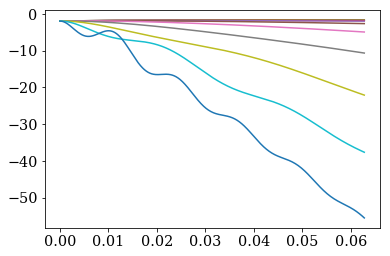

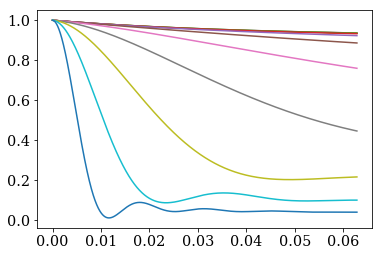

In [10]:
# plot some outputs for sanity check
plt.plot(τ_solve, δd.T[:, 0::25])
plt.show()
plt.plot(τ_solve, Φ.T[:, 0::25])
plt.show()